In [1]:
import mdtraj as md
import pymbar
import panedr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.style.use("ggplot")

# Chloroform Freezing Investigation

When creating a the heat capacity curve for replica exchange simualtions, we observed a large spike in heat capacity at $225K$. Being skeptical of this large spike, we want to examine the possible hypothesis that the cholroform is freezing at such a low temperature. This is difficult to examine in an REMD simulation, therefore we ran an additional vanilla MD simulationat 225K to explore this hypthesis with a continuous trajectory MD simulation.

In [2]:
traj = md.load(["/mnt/summit/simulations/octamer_Rchiral/RHH/md_sims/chloroform_freezing/npt.nojump.xtc"],
               top = "/mnt/summit/simulations/octamer_Rchiral/RHH/md_sims/chloroform_freezing/berendsen.gro")
print(traj)

<mdtraj.Trajectory with 3242 frames, 6678 atoms, 1262 residues, and unitcells>


In [3]:
energy_df = panedr.edr_to_df("/mnt/summit/simulations/octamer_Rchiral/RHH/md_sims/chloroform_freezing/npt.edr")

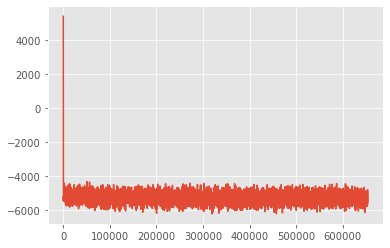

In [4]:
plt.plot(energy_df["Total Energy"])

Text(0, 0.5, 'MSD to reference frame')

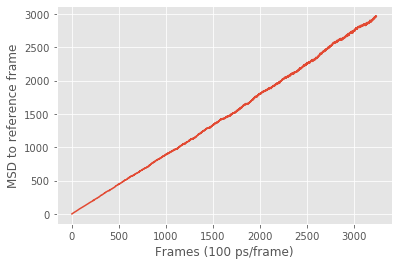

In [14]:
# Total RMSD
rmsds = md.rmsd(traj, traj)
plt.plot(rmsds**2)
plt.xlabel("Frames (100 ps/frame)")
plt.ylabel("MSD to reference frame")

Text(0, 0.5, 'RMSD to reference frame')

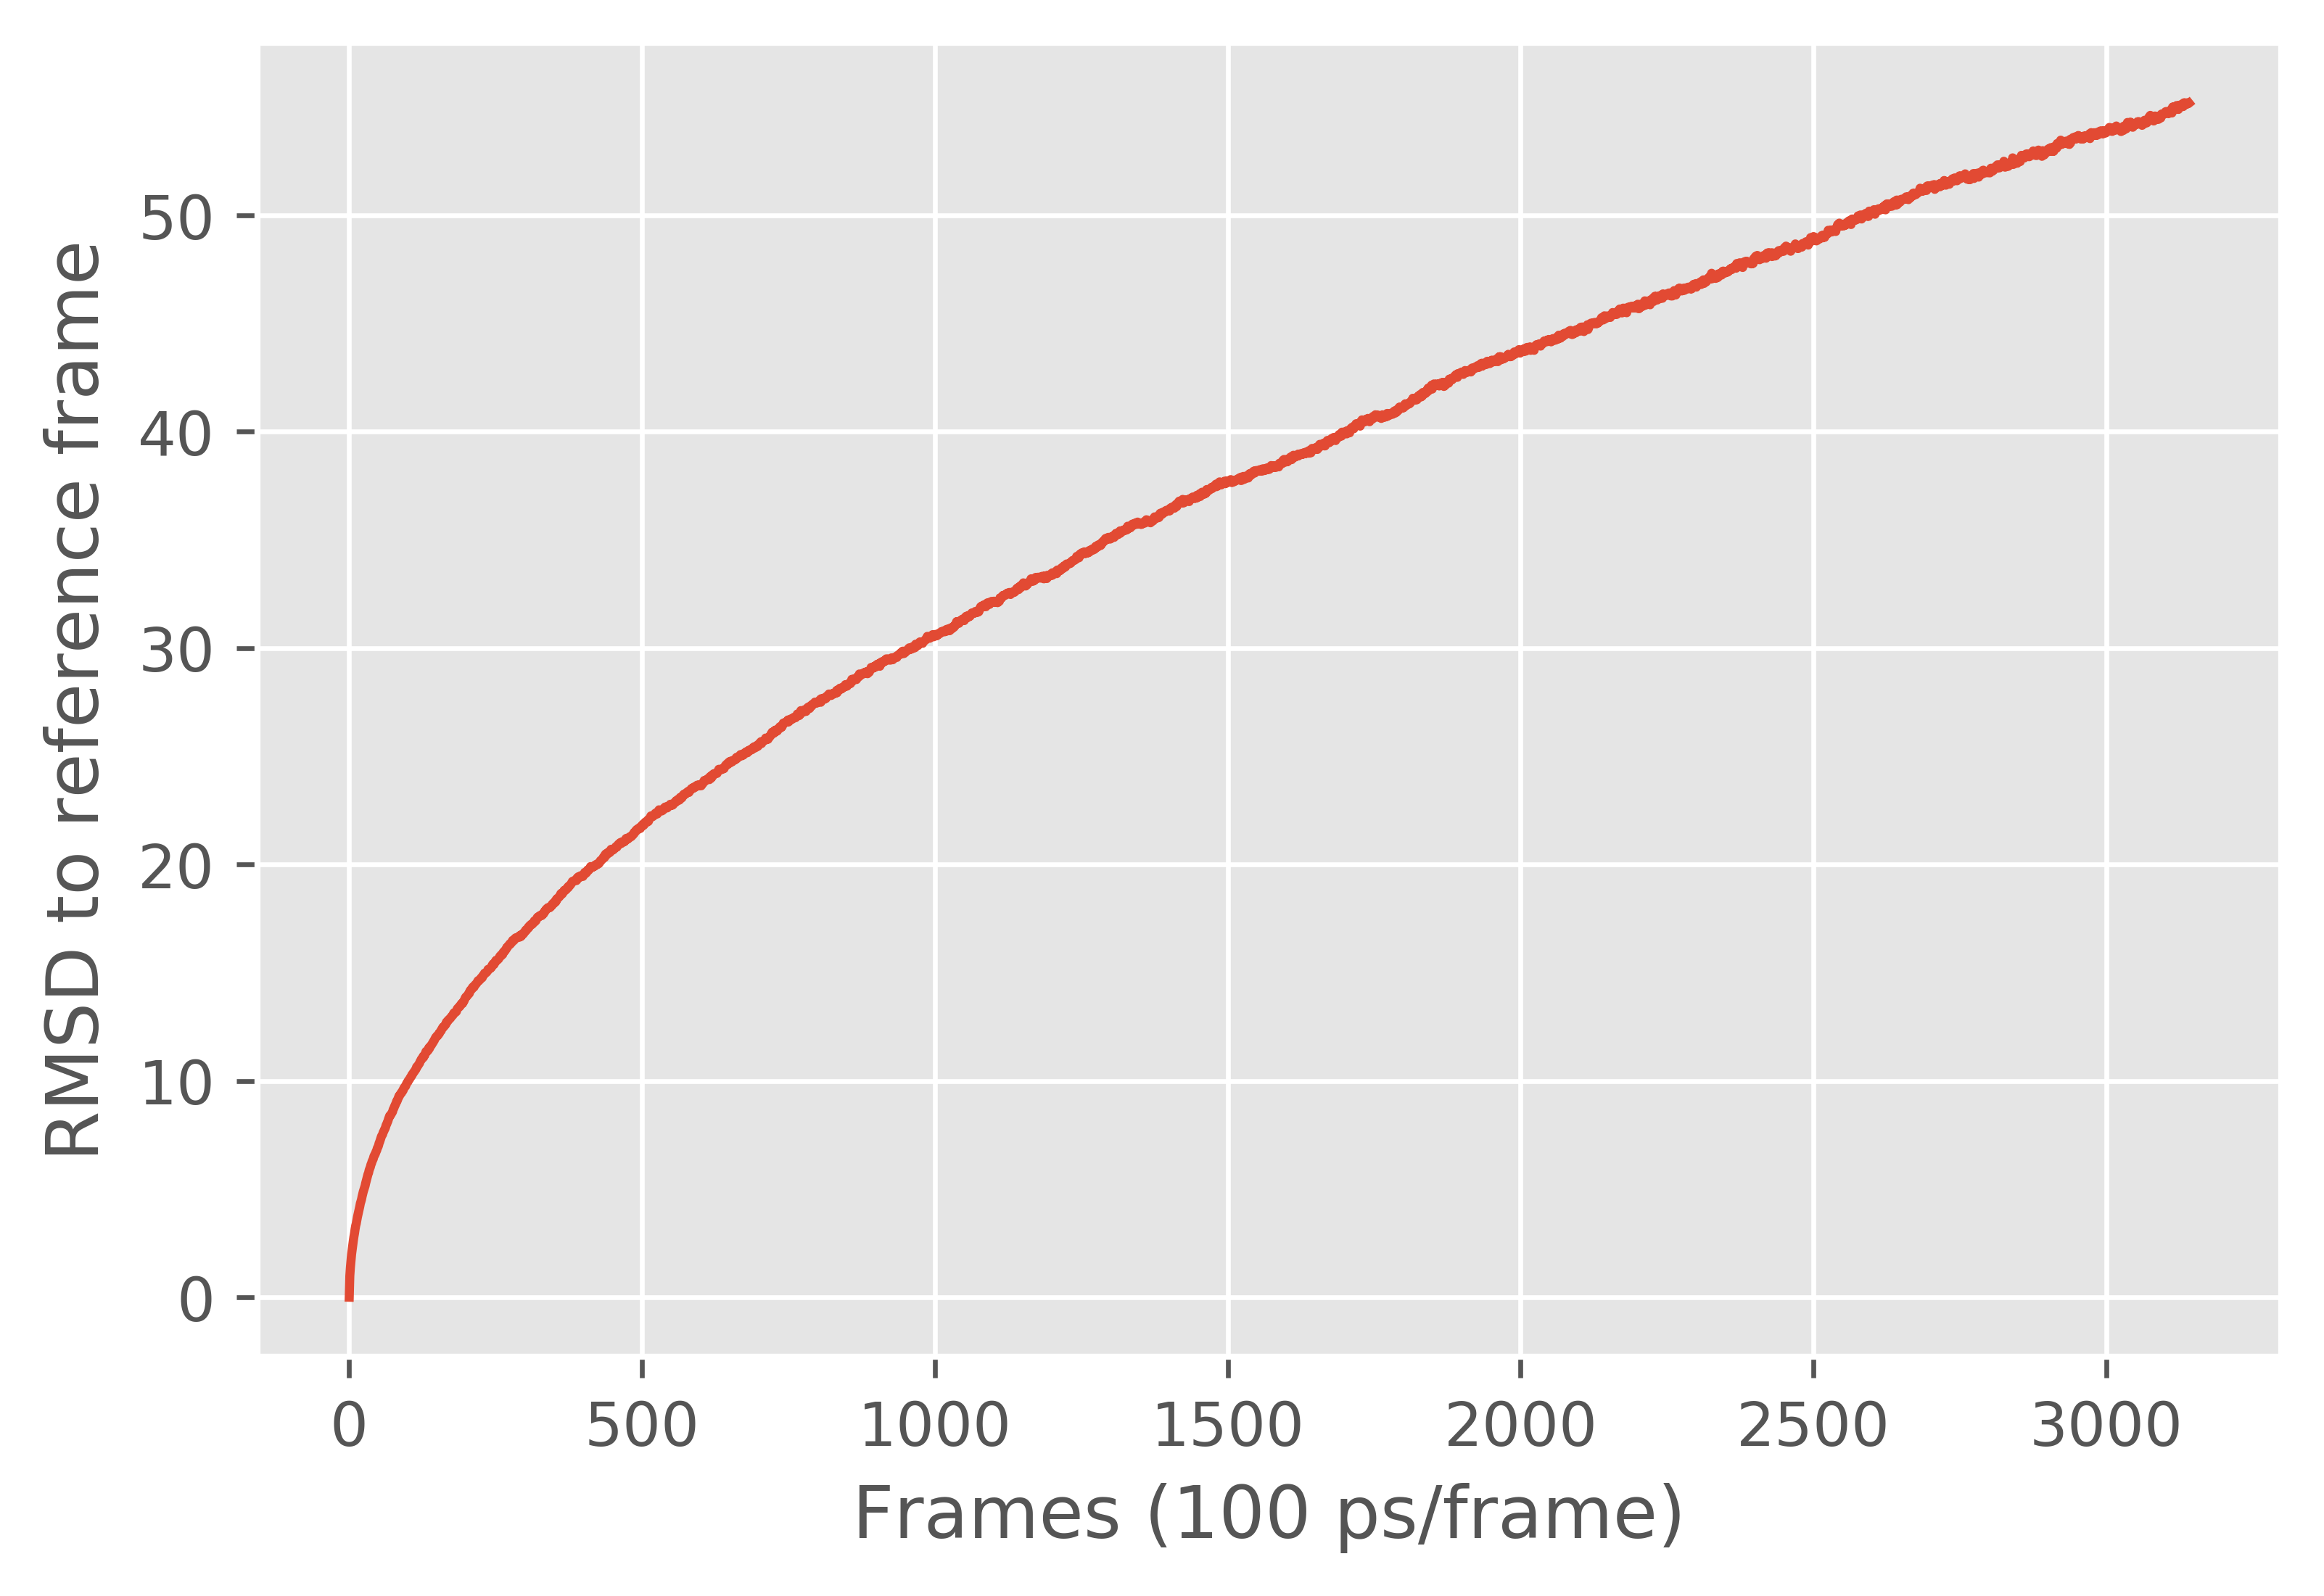

In [23]:
top = traj.topology
chloroform_centers = top.select("not resname OCT and name C1")

# Chloroform center RMSDs
rmsd = md.rmsd(traj[100:], traj[100], atom_indices = chloroform_centers)
plt.figure(dpi=600)
plt.plot(rmsd)
plt.xlabel("Frames (100 ps/frame)")
plt.ylabel("RMSD to reference frame")

In [7]:
len(chloroform_centers)

1261

In [61]:
# With bootstrapping

n_boots = 100
boot_size = len(chloroform_centers)
bootstrapped_rmsds = []

for _ in range(n_boots):
    boot_indexes = np.random.choice(chloroform_centers, size = boot_size, replace = True)
    rmsd = md.rmsd(traj, traj, atom_indices = boot_indexes)
    bootstrapped_rmsds.append(rmsd)


In [62]:
t_dist = scipy.stats.t(len(bootstrapped_rmsds)-1)
t_dist.ppf(0.95)

1.6603911559963895

Text(0, 0.5, 'RMSD of Chloroform Centers')

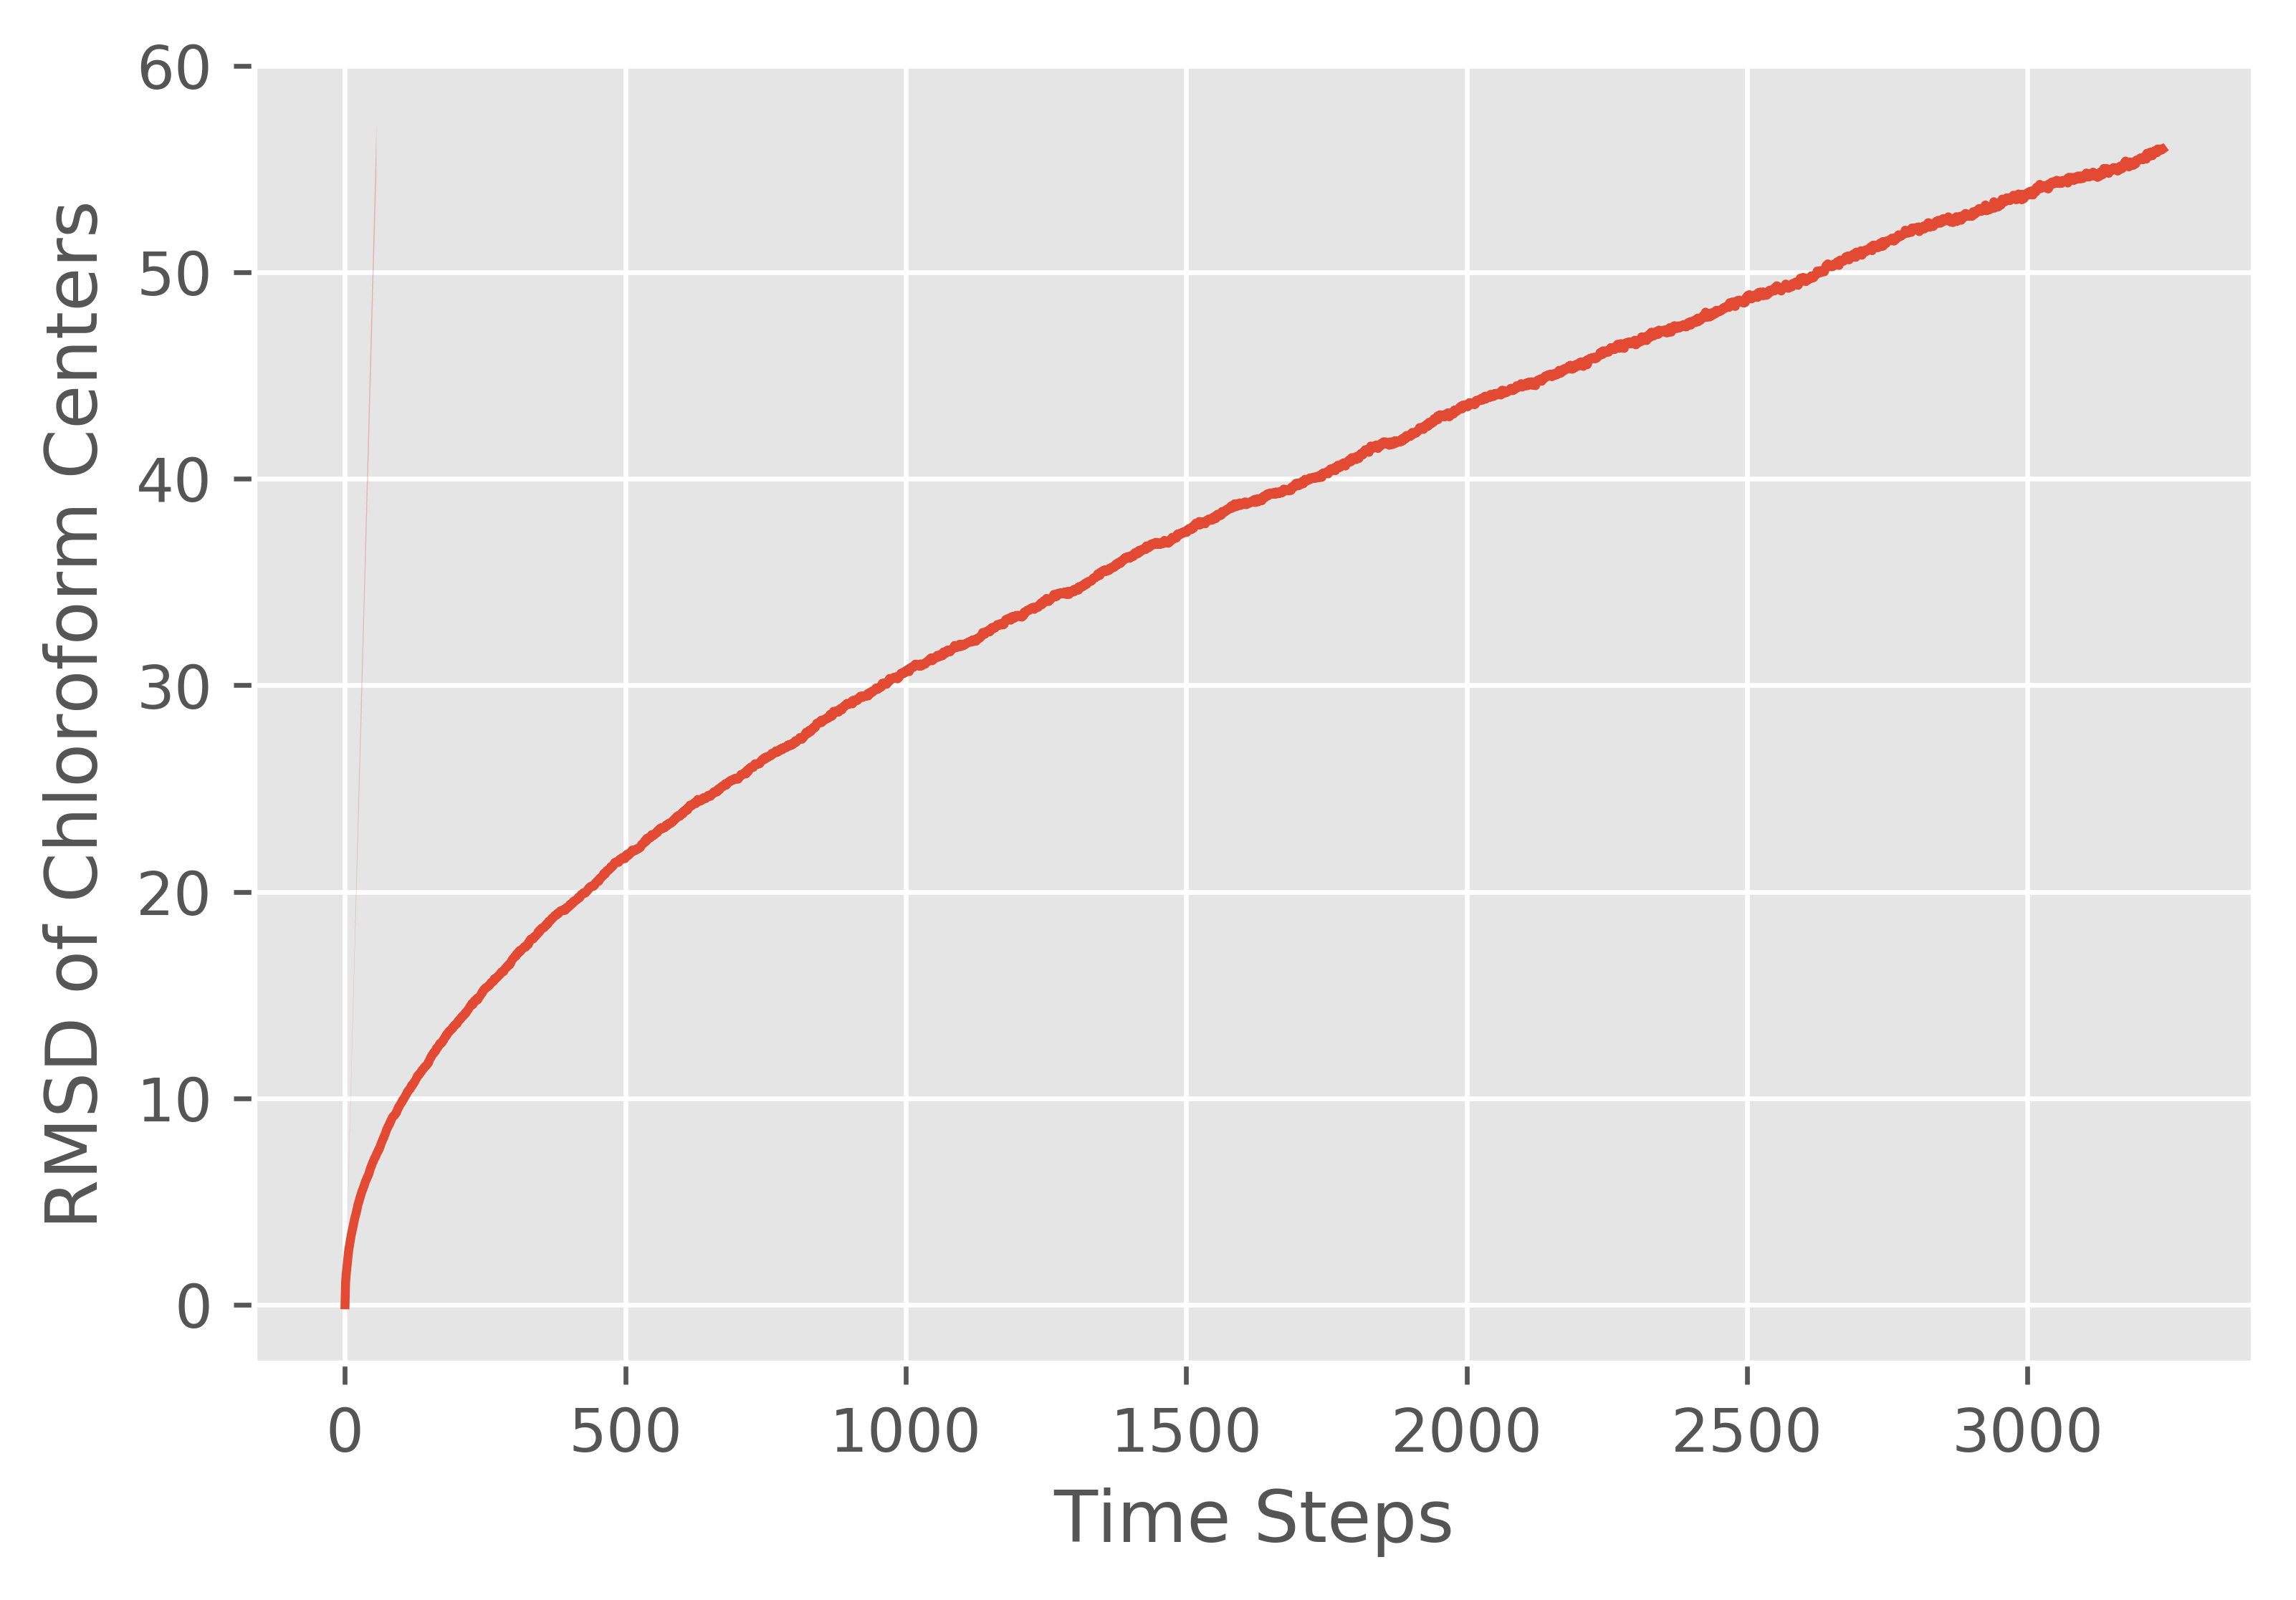

In [63]:
bootstrapped_rmsds = np.array(bootstrapped_rmsds)
bs_mean = np.mean(bootstrapped_rmsds, axis=0)
bs_std = np.std(bootstrapped_rmsds, axis=0)

bs_upper = bs_mean + 2*bs_std
bs_lower = bs_mean -  2*bs_std

plt.figure(dpi = 600)
plt.plot(bs_mean)
plt.fill_between(bs_mean, bs_lower, bs_upper, alpha = 0.3)
plt.xlabel("Time Steps")
plt.ylabel("RMSD of Chloroform Centers")

## Single Atom RMSDs

MDTraj centers atom positions when doing RMSD calculations, making it difficult to calculate single atom RMSDs over the course of a simulation. I plan to implement a simple single atom RMSD, to confirm that the overal RMSD given by MDTraj is accurate.

In [64]:
chloroform_centers

array([ 373,  378,  383, ..., 6663, 6668, 6673])

In [65]:
test_traj = traj.atom_slice(chloroform_centers[0:1])

In [66]:
test_traj.xyz.shape

(3242, 1, 3)

In [67]:
all_disp = []
for atom in chloroform_centers:
    displacements = []
    test_traj = traj.atom_slice([atom])
    for frame in range(1, test_traj.xyz.shape[0]):
        d = np.sqrt(np.sum(np.power(test_traj.xyz[frame] - test_traj.xyz[0], 2)))
        displacements.append(d)
    all_disp.append(displacements)

all_disp = np.array(all_disp)

Text(0.5, 0, 'Time Steps')

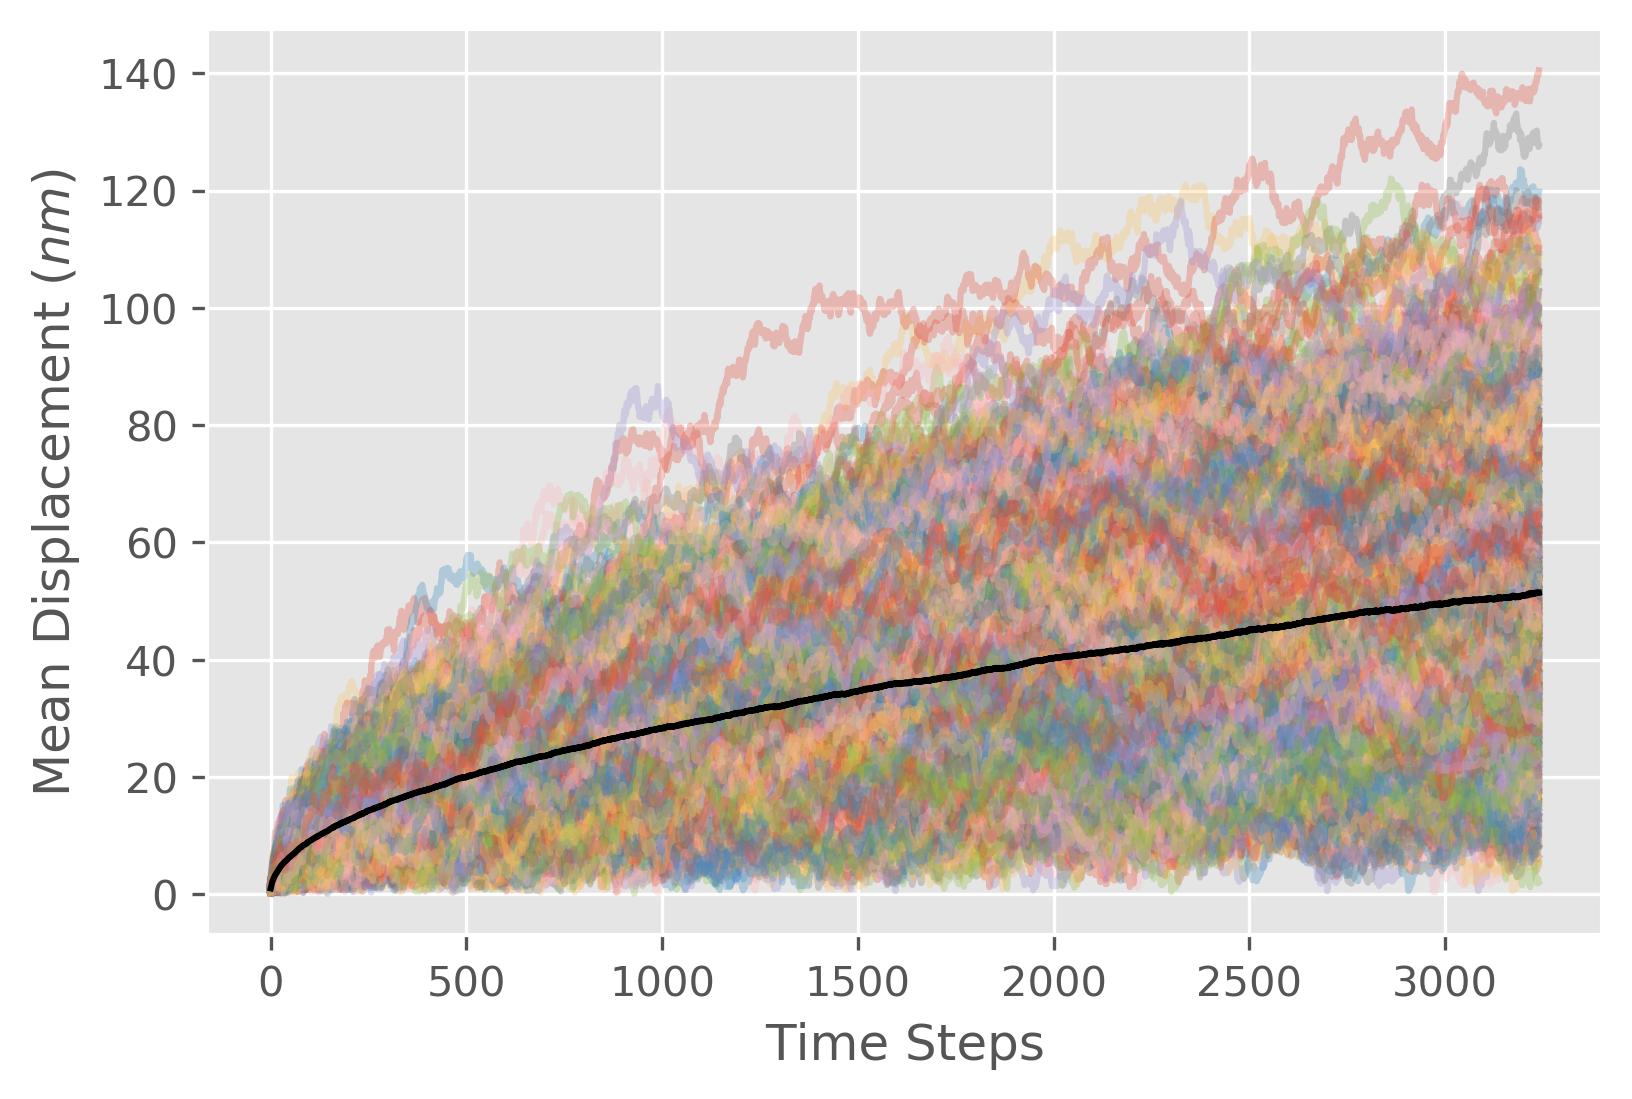

In [73]:
plt.figure(dpi=300)
for disp in all_disp:
    plt.plot(disp, alpha = 0.3)

plt.plot(np.mean(all_disp, axis = 0), color = "black")
plt.ylabel("Mean Displacement ($nm$)")
plt.xlabel("Time Steps")